In [544]:
%matplotlib inline

from IPython.display import display
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols

In [545]:
MAX_EDIT_TIME_WORD = 20
MAX_EDIT_TIME = 300
FILTER_FIRST = True

REMOVE_ALL_OCCURRENCES = True

In [546]:
bleu_scores = (
    ('src', 0, 0),                                                                           
    ('ref', 100, 100),
    ('m01', 25.35, 19.07),
    ('m02', 31.61, 22.44),
    ('m03', 33.09, 23.86),
    ('m04', 33.63, 24.42),
    ('m05', 35.22, 26.25),
    ('m06', 35.68, 26.64),
    ('m07', 36.58, 28.14),
    ('m08', 36.41, 28.84),
    ('m09', 37.40, 28.72),
    ('m10', 37.44, 28.95),
    ('m11', 37.37, 28.46),
    ('google', 37.56, 26.06),
    ('microsoft', 33.06, 26.30),
)

bleu_docs = {system: bleu_docs for system, bleu_docs, bleu_wmt in bleu_scores}
bleu_wmt = {system: bleu_wmt for system, bleu_docs, bleu_wmt in bleu_scores}

bleu_scores_df = pd.DataFrame(bleu_scores, columns=("mt_name", "bleu_docs", "bleu_wmt"))

In [547]:
df = pd.read_json("../../docs/memsource/data-after-phase-1.json", lines=True).merge(bleu_scores_df, on=["mt_name"])

In [548]:
# filtering step
sentences_to_remove = set()

if FILTER_FIRST:
    df = df[df["is_first"] == 0]
    
if MAX_EDIT_TIME_WORD:
    sentences_to_remove.union(df[df["edit_time_word"] >= MAX_EDIT_TIME_WORD]["source"])
    df = df[df["edit_time_word"] < MAX_EDIT_TIME_WORD]

if MAX_EDIT_TIME:
    sentences_to_remove.union(df[df["edit_time"] >= MAX_EDIT_TIME]["source"])
    df = df[df["edit_time"] < MAX_EDIT_TIME]

if REMOVE_ALL_OCCURRENCES:
    df = df[~df["source"].isin(sentences_to_remove)]

df = df[~df["mt_name"].isin([
    # "m08", "m09", "m10", "m11", "google",
    # "ref", "src",
])]

In [549]:
df["source_words"] = df.apply(lambda r: len(r['source'].split()), 'columns')

# df = df[(df["source_words"] >= 10) & (df["source_words"] < 30)]

In [550]:
df.columns

Index(['comments', 'doc_name', 'edit_time', 'edit_time_word', 'is_first',
       'is_last', 'job_uid', 'mt_name', 'provided', 'source', 'target',
       'think_time', 'think_time_word', 'tunit_id', 'user_a', 'bleu_docs',
       'bleu_wmt', 'source_words'],
      dtype='object')

In [551]:
aggregations = {
    "total_edit_time": ("edit_time", "sum"),
    "total_source_words": ("source_words", "sum"),
    "mean_edit_time": ("edit_time", "mean"),    
}

docs_df = df.groupby(["doc_name", "mt_name", "user_a"]).agg(**aggregations).reset_index()

docs_df["mean_edit_time_word"] = docs_df.apply(lambda r: r["total_edit_time"] / r["total_source_words"], 1)

docs_df

,doc_name,mt_name,user_a,total_edit_time,total_source_words,mean_edit_time,mean_edit_time_word
0,audit_i,google,3,842.258,432,52.641125,1.949671
1,audit_i,m01,6,1765.582,381,117.705467,4.634073
2,audit_i,m02,12,721.225,329,51.516071,2.192173
3,audit_i,m03,2,478.086,432,29.880375,1.106681
4,audit_i,m04,8,418.570,95,139.523333,4.406000
...,...,...,...,...,...,...,...
112,whistle,m10,2,296.645,210,59.329000,1.412595
113,whistle,m11,6,616.042,188,154.010500,3.276819
114,whistle,microsoft,9,449.078,136,149.692667,3.302044
115,whistle,ref,10,658.593,210,131.718600,3.136157


In [552]:
import re

def _parse_model_params(model, variable, base):
    params = model.params.to_dict()
    parsed = {base: 0}
    for k, v in params.items():
        match = re.match(f"C\({variable}.*\)\[T.(.*)\]", k)
        if match:
            parsed[match.group(1)] = v
    
    return parsed    

def analyze_model(model_definition, df, plot_mt=True, base=None):
    model = ols(model_definition, data=df)
    fitted_model = model.fit()
    display(fitted_model.summary())    
    if plot_mt:
        parsed_params = _parse_model_params(fitted_model, "mt_name", base)
        
        list_labels = sorted(parsed_params, key=bleu_docs.get)
        list_bleu = [bleu_docs[k] for k in list_labels]        
        list_params = [parsed_params[k] for k in list_labels]
        
        print("Correlation with docs BLEU:")
        print(stats.spearmanr(list_params, list_bleu))       
        print(stats.pearsonr(list_params, list_bleu))       
       
        plt.bar(list_labels, list_params)
        plt.show()
    print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         edit_time_word   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     13.58
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           5.54e-64
Time:                        15:48:18   Log-Likelihood:                -2818.8
No. Observations:                1166   AIC:                             5710.
Df Residuals:                    1130   BIC:                             5892.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     4.4820      0.431     10.395      0.000       3.636       5.328
C(user_a)[T.1]                                3.8159      0.506      7.535      0.000       2.822       4.809
C(user_a)[T.2]                               -2.1128      0.444     -4.763      0.000      -2.983      -1.242
C(user_a)[T.3]                               -0.2511      0.458     -0.548      0.584      -1.151       0.648
C(user_a)[T.4]                               -0.6210      0.467     -1.329      0.184      -1.538       0.296
C(user_a)[T.5]                                2.0589      0.485      4.249      0.000       1.108       3.010
C(user_a)[T.6]                                0.8874      0.487      1.822      0.069      -0.068       1.843
C(user_a)[T.7]                                1.5841      0.510      3.106      0.002       0.583       2.585
C(user_a)[T.8]                                4.9532      0.642      7.709      0.000       3.693       6.214
C(user_a)[T.9]                                0.8815      0.494      1.786      0.074      -0.087       1.850
C(user_a)[T.10]                              -1.1468      0.469     -2.446      0.015      -2.067      -0.227
C(user_a)[T.11]                               0.5155      0.472      1.092      0.275      -0.411       1.441
C(user_a)[T.12]                              -0.8102      0.460     -1.761      0.078      -1.713       0.092
C(user_a)[T.13]                              -1.0863      0.444     -2.447      0.015      -1.957      -0.215
C(user_a)[T.14]                               0.8520      0.434      1.963      0.050       0.000       1.704
C(mt_name, Treatment("src"))[T.google]       -0.4666      0.470     -0.993      0.321      -1.388       0.455
C(mt_name, Treatment("src"))[T.m01]          -0.5689      0.490     -1.160      0.246      -1.531       0.393
C(mt_name, Treatment("src"))[T.m02]          -0.5284      0.488     -1.082      0.280      -1.487       0.430
C(mt_name, Treatment("src"))[T.m03]          -0.6435      0.455     -1.415      0.157      -1.536       0.249
C(mt_name, Treatment("src"))[T.m04]          -1.4552      0.521     -2.791      0.005      -2.478      -0.432
C(mt_name, Treatment("src"))[T.m05]          -0.3768      0.503     -0.749      0.454      -1.364       0.610
C(mt_name, Treatment("src"))[T.m06]          -1.8232      0.519     -3.514      0.000      -2.841      -0.805
C(mt_name, Treatment("src"))[T.m07]          -1.3858      0.482     -2.873      0.004      -2.332      -0.439
C(mt_name, Treatment("src"))[T.m08]          -0.7855      0.471     -1.669      0.095      -1.709       0.138
C(mt_name, Treatment("src"))[T.m09]          -0.4302      0.473     -0.909      0.364      -1.359       0.498
C(m

Correlation with docs BLEU:
SpearmanrResult(correlation=-0.3214285714285714, pvalue=0.24271904680166836)
(-0.5110979963166777, 0.05152036547048747)


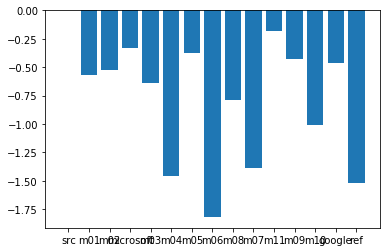

In [553]:
analyze_model('edit_time_word ~ C(user_a) + C(mt_name, Treatment("src")) + C(doc_name)', df, base="src")

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_edit_time_word   R-squared:                       0.720
Model:                             OLS   Adj. R-squared:                  0.598
Method:                  Least Squares   F-statistic:                     5.938
Date:                 Wed, 23 Dec 2020   Prob (F-statistic):           2.04e-11
Time:                         15:48:18   Log-Likelihood:                -177.68
No. Observations:                  117   AIC:                             427.4
Df Residuals:                       81   BIC:                             526.8
Df Model:                           35                                         
Covariance Type:             nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     4.1204      0.726      5.673      0.000       2.675       5.566
C(user_a)[T.1]                                3.2781      0.700      4.686      0.000       1.886       4.670
C(user_a)[T.2]                               -1.7282      0.678     -2.550      0.013      -3.077      -0.379
C(user_a)[T.3]                               -0.2530      0.686     -0.369      0.713      -1.618       1.112
C(user_a)[T.4]                               -0.1466      0.694     -0.211      0.833      -1.528       1.235
C(user_a)[T.5]                                2.1362      0.703      3.040      0.003       0.738       3.534
C(user_a)[T.6]                                0.8398      0.710      1.183      0.240      -0.573       2.253
C(user_a)[T.7]                                1.4984      0.716      2.092      0.040       0.073       2.924
C(user_a)[T.8]                                4.9211      0.776      6.345      0.000       3.378       6.464
C(user_a)[T.9]                                1.0176      0.710      1.433      0.156      -0.395       2.430
C(user_a)[T.10]                              -0.7997      0.703     -1.138      0.258      -2.198       0.598
C(user_a)[T.11]                               0.6277      0.695      0.904      0.369      -0.754       2.010
C(user_a)[T.12]                              -0.5020      0.686     -0.732      0.466      -1.867       0.863
C(user_a)[T.13]                              -0.8769      0.678     -1.294      0.199      -2.225       0.472
C(user_a)[T.14]                               0.9682      0.670      1.444      0.153      -0.366       2.302
C(mt_name, Treatment("src"))[T.google]       -0.2446      0.677     -0.361      0.719      -1.592       1.103
C(mt_name, Treatment("src"))[T.m01]          -0.6696      0.736     -0.909      0.366      -2.135       0.796
C(mt_name, Treatment("src"))[T.m02]          -1.2594      0.696     -1.810      0.074      -2.644       0.125
C(mt_name, Treatment("src"))[T.m03]          -1.1408      0.670     -1.703      0.092      -2.474       0.192
C(mt_name, Treatment("src"))[T.m04]          -1.8638      0.718     -2.596      0.011      -3.292      -0.435
C(mt_name, Treatment("src"))[T.m05]          -0.7774      0.712     -1.093      0.278      -2.193       0.638
C(mt_name, Treatment("src"))[T.m06]          -1.7176      0.718     -2.392      0.019      -3.146      -0.289
C(mt_name, Treatment("src"))[T.m07]          -1.8733      0.694     -2.698      0.008      -3.255      -0.492
C(mt_name, Treatment("src"))[T.m08]          -1.8278      0.686     -2.666      0.009      -3.192      -0.463
C(mt_name, Treatment("src"))[T.m09]          -0.7860      0.687     -1.144      0.256      -2.154     

Correlation with docs BLEU:
SpearmanrResult(correlation=-0.15714285714285714, pvalue=0.5759526006037947)
(-0.49867158379864274, 0.05847304131050542)


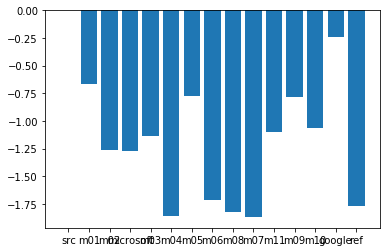

In [554]:
analyze_model('mean_edit_time_word ~ C(user_a) + C(mt_name, Treatment("src")) + C(doc_name)', docs_df, base="src")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mean_edit_time   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     10.39
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           3.99e-18
Time:                        15:48:18   Log-Likelihood:                -539.86
No. Observations:                 117   AIC:                             1152.
Df Residuals:                      81   BIC:                             1251.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    99.6482     16.053      6.208      0.000      67.709     131.588
C(user_a)[T.1]                               51.9886     15.460      3.363      0.001      21.229      82.749
C(user_a)[T.2]                              -45.8194     14.980     -3.059      0.003     -75.626     -16.013
C(user_a)[T.3]                               -2.3848     15.160     -0.157      0.875     -32.548      27.778
C(user_a)[T.4]                                6.5116     15.346      0.424      0.672     -24.021      37.044
C(user_a)[T.5]                               59.6433     15.530      3.841      0.000      28.744      90.542
C(user_a)[T.6]                               31.1503     15.693      1.985      0.051      -0.073      62.373
C(user_a)[T.7]                               35.3867     15.830      2.235      0.028       3.890      66.884
C(user_a)[T.8]                               89.2383     17.140      5.207      0.000      55.136     123.341
C(user_a)[T.9]                               25.6769     15.693      1.636      0.106      -5.548      56.901
C(user_a)[T.10]                             -20.3658     15.529     -1.311      0.193     -51.264      10.532
C(user_a)[T.11]                              22.9779     15.349      1.497      0.138      -7.562      53.517
C(user_a)[T.12]                             -15.1088     15.163     -0.996      0.322     -45.279      15.061
C(user_a)[T.13]                             -23.6359     14.978     -1.578      0.118     -53.438       6.166
C(user_a)[T.14]                              31.5505     14.816      2.130      0.036       2.072      61.029
C(mt_name, Treatment("src"))[T.google]      -11.9520     14.970     -0.798      0.427     -41.738      17.834
C(mt_name, Treatment("src"))[T.m01]         -15.8175     16.275     -0.972      0.334     -48.200      16.565
C(mt_name, Treatment("src"))[T.m02]         -25.7870     15.377     -1.677      0.097     -56.382       4.808
C(mt_name, Treatment("src"))[T.m03]         -18.0448     14.806     -1.219      0.226     -47.504      11.414
C(mt_name, Treatment("src"))[T.m04]         -34.1003     15.868     -2.149      0.035     -65.672      -2.529
C(mt_name, Treatment("src"))[T.m05]         -18.6472     15.726     -1.186      0.239     -49.937      12.642
C(mt_name, Treatment("src"))[T.m06]         -34.0525     15.867     -2.146      0.035     -65.623      -2.482
C(mt_name, Treatment("src"))[T.m07]         -48.6718     15.344     -3.172      0.002     -79.201     -18.142
C(mt_name, Treatment("src"))[T.m08]         -34.2938     15.154     -2.263      0.026     -64.445      -4.143
C(mt_name, Treatment("src"))[T.m09]         -20.8815     15.190     -1.375      0.173     -51.104       9.341
C(m

Correlation with docs BLEU:
SpearmanrResult(correlation=-0.47142857142857136, pvalue=0.07607042915033121)
(-0.48343938077513093, 0.06789947295026429)


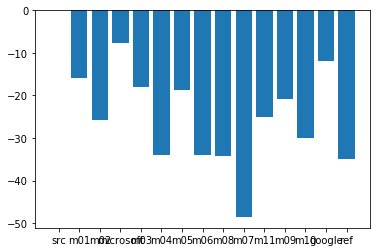

In [555]:
analyze_model('mean_edit_time ~ C(user_a) + C(mt_name, Treatment("src")) + C(doc_name)', docs_df, base="src")